In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dateutil.parser
import numpy as np

from tqdm import tqdm
from datetime import timedelta
from sklearn.decomposition import NMF


In [2]:
tqdm.pandas()

In [3]:
billboard_hot_100 = pd.read_csv("billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)
billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year

billboard_hot_100.head()

,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,songwriters,producers,promotion_label,year
0,0,1958-09-08,Domenico Modugno,Nel Blu Dipinto Di Blu (Volare),1,1.0,1,6,"F.Migliacci, D.Modugno",Not Listed,Decca,1958
1,1,1958-09-08,The Elegants,Little Star,2,2.0,1,6,"V.Picone, A.Venosa",Not Listed,Apt,1958
2,2,1958-09-08,The Everly Brothers,Bird Dog,3,3.0,3,6,B.Bryant,Not Listed,Cadence,1958
3,3,1958-09-08,Jimmy Clanton And His Rockets,Just A Dream,4,4.0,4,6,Not Listed,Not Listed,Ace,1958
4,4,1958-09-08,Perez Prado And His Orchestra,Patricia,5,6.0,2,6,"B.Marcus, P.Prado",Not Listed,RCA Victor,1958


In [4]:
plt.rcParams.update({'font.size': 15})

In [5]:
billboard_hot_100["top_position"] = billboard_hot_100.groupby(
    ["artist", "song_name"])["position"].transform("min")

In [6]:
# concatenate artist and song name
billboard_hot_100["artist_song"] = billboard_hot_100["artist"] + " - " +\
    billboard_hot_100["song_name"]
billboard_hot_100["first_week"] = billboard_hot_100.groupby(["artist", "song_name"])["first_day_of_the_week"].transform("min")
billboard_hot_100["last_week"] = billboard_hot_100.groupby(["artist", "song_name"])["first_day_of_the_week"].transform("max")
billboard_hot_100["start_end_week_diff"] = (billboard_hot_100["last_week"] - billboard_hot_100["first_week"]).dt.days / 7

In [7]:
min_first_week = billboard_hot_100["first_day_of_the_week"].min().to_pydatetime()
billboard_hot_100["first_day_of_the_week_copy"] = billboard_hot_100["first_day_of_the_week"]
billboard_hot_100["first_day_of_the_week"] = billboard_hot_100.progress_apply(lambda row:
            int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

100%|██████████| 336087/336087 [00:08<00:00, 39347.59it/s]


In [8]:
billboard_hot_100 = billboard_hot_100[(billboard_hot_100["start_end_week_diff"] <= 100) & (billboard_hot_100["top_position"] <= 10)]

pv_table = billboard_hot_100[billboard_hot_100["start_end_week_diff"] <= 100].pivot_table(index="first_day_of_the_week",
        columns="artist_song", values="position", fill_value=101)

In [9]:
pv_table

artist_song,"""Weird Al"" Yankovic - White & Nerdy",'N Sync & Gloria Estefan - Music Of My Heart,'N Sync - (God Must Have Spent) A Little More Time On You,'N Sync - Bye Bye Bye,'N Sync - It's Gonna Be Me,'N Sync - This I Promise You,'N Sync Featuring Nelly - Girlfriend,'Til Tuesday - Voices Carry,100 Proof Aged in Soul - Somebody's Been Sleeping,10cc - I'm Not In Love,...,fun. - Some Nights,fun. Featuring Janelle Monae - We Are Young,gnash Featuring Olivia O'Brien - I Hate U I Love U,matchbox twenty - Bent,matchbox twenty - If You're Gone,matchbox twenty - Unwell,twenty one pilots - Heathens,twenty one pilots - Ride,twenty one pilots - Stressed Out,will.i.am & Britney Spears - Scream & Shout
first_day_of_the_week,,,,,,,,,,,,,,,,,,,,,
0,28,66,60,42,82,68,70,81,81,84,...,62,53,93,60,52,59,14,96,87,12
1,9,56,57,20,70,31,55,71,75,74,...,89,78,96,37,43,49,18,96,101,13
2,11,52,44,19,51,19,30,61,52,64,...,82,101,99,29,38,44,26,88,101,15
3,15,52,34,14,39,15,22,55,43,49,...,76,101,78,24,30,39,23,87,97,12
4,17,41,35,13,26,11,18,45,37,38,...,70,88,76,22,29,34,22,78,101,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,101,101,101,101,101,101,101,101,101,101,...,101,101,101,101,101,101,101,101,101,101
96,101,101,101,101,101,101,101,101,101,101,...,101,101,101,101,101,101,101,101,101,101
97,101,101,101,101,101,101,101,101,101,101,...,101,101,101,101,101,101,101,101,101,101


In [10]:
nmf = NMF(n_components=6, init='random', random_state=0)
nmf.fit(pv_table)

c:\Users\cutie\source\repos\mgr\env\Lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF(init='random', n_components=6, random_state=0)

In [11]:
nmf_features = nmf.transform(pv_table)

In [12]:
def display_components(model, song_names, num_top_positions):
    # iterate through topics in topic-term matrix, 'H' aka
    # model.components_
    for ix, archetype in enumerate(model.components_):
        #print topic, topic number, and top words
        print("\nArchetype ", ix)
        print(", ".join([song_names[i] \
             for i in archetype.argsort()[:-num_top_positions - 1:-1]]))

In [13]:
display_components(nmf, billboard_hot_100["artist_song"].values, 5)


Archetype  0
The Playmates - Beep Beep, Anita Bryant - Paper Roses, Ernie Fields & Orch. - In The Mood, Paul Anka - Dance On Little Girl, Brenda Lee - Fool #1

Archetype  1
Bob Luman - Let's Think About Living, Hank Ballard And The Midnighters - Let's Go, Let's Go, Let's Go, LaVern Baker - I Cried A Tear, Bob Moore and His Orch. - Mexico, Dion - Runaround Sue

Archetype  2
Elvis Presley With The Jordanaires - Surrender, Lloyd Price and His Orchestra - Personality, The Platters - Harbor Lights, Neil Sedaka - Happy Birthday, Sweet Sixteen, Bobby Rydell - We Got Love

Archetype  3
The Dovells - Bristol Stomp, Donnie Brooks - Mission Bell, Poni-Tails - Born Too Late, Neil Sedaka - Happy Birthday, Sweet Sixteen, The Shirelles - Dedicated To The One I Love

Archetype  4
Elvis Presley With The Jordanaires - Stuck On You, Sandy Nelson - Let There Be Drums, Lloyd Price and His Orchestra - Personality, The String-A-Longs - Wheels, Sammy Turner - Lavender-Blue

Archetype  5
Timi Yuro - Hurt, Rog

In [14]:
# Create a DataFrame: components_df
components_df = pd.DataFrame(nmf.components_, columns=billboard_hot_100["artist_song"].drop_duplicates().values)
components_df

,Domenico Modugno - Nel Blu Dipinto Di Blu (Volare),The Elegants - Little Star,The Everly Brothers - Bird Dog,Jimmy Clanton And His Rockets - Just A Dream,Perez Prado And His Orchestra - Patricia,Ricky Nelson - Poor Little Fool,Jack Scott - My True Love,Bobby Day - Rock-in Robin,Frankie Avalon - Ginger Bread,The Olympics - Western Movies,...,Taylor Swift - Bejeweled,Taylor Swift - Question...?,"Taylor Swift - You're On Your Own, Kid",Taylor Swift - Karma,Taylor Swift - Vigilante Shit,Rihanna - Lift Me Up,"Metro Boomin, The Weeknd & 21 Savage - Creepin'","Metro Boomin, Future & Chris Brown - Superhero (Heroes & Villains)",SZA - Kill Bill,SZA - Nobody Gets Me
0,3.508927,3.672710,2.693215,3.696719,3.209158,3.973612,3.344215,2.456036,3.672802,3.290973,...,3.830482,5.023280,4.472985,6.243416,6.207544,5.979160,6.743617,4.483861,0.000000,3.989949
1,0.022665,3.368727,1.897998,1.632203,4.241164,3.176672,2.729382,3.029164,4.963101,4.792205,...,0.000000,1.830547,2.268552,3.036265,2.434749,0.574560,2.259550,3.686048,0.000000,1.363936
2,2.490225,4.961317,0.407574,0.000000,0.000000,0.000000,1.884033,1.671185,5.627542,4.216836,...,1.412241,0.000000,0.598809,0.001263,0.361371,0.462401,0.000000,0.000000,6.284405,0.000000
3,2.777469,1.861294,3.499179,0.455564,1.574014,0.000000,1.195304,3.986274,1.389556,1.663846,...,11.409874,7.910886,7.571263,0.821406,1.686263,4.377163,0.000000,6.811428,15.103520,0.043285
4,4.271209,4.394099,0.722154,0.752080,0.000000,1.427707,0.000000,0.000000,2.094639,0.000000,...,0.111924,0.000000,2.315129,0.487637,0.328967,0.000000,0.909000,0.105597,2.034445,1.397001
5,7.833827,2.515373,9.509363,9.429859,6.597647,6.298245,8.341238,8.345748,1.880296,4.632871,...,0.000000,0.000000,0.000000,0.248788,0.402674,0.000000,0.353555,0.000000,0.000000,8.899398


In [15]:
# get all artist-songs for archetypes
archetypes = {i: [] for i in range(6)}
for artist_song in components_df.columns:
    archetype = components_df[artist_song].argmax()
    archetypes[archetype].append(artist_song)


In [16]:
nmf_features_pd = pd.DataFrame(nmf_features)

nmf_features_pd

,0,1,2,3,4,5
0,1.392759,14.598089,1.649903,4.114908,0.000000,0.958253
1,0.000000,12.440649,0.279111,6.590656,0.000000,0.250681
2,0.000000,8.771491,0.000000,7.815502,0.000000,0.066011
3,0.000000,5.867539,0.000000,8.323497,0.000000,0.009108
4,0.000000,3.745795,0.000000,8.448371,0.000000,0.000000
...,...,...,...,...,...,...
95,12.902115,5.632649,1.486372,4.030560,2.141780,4.174816
96,12.876766,5.653722,1.482635,4.041767,2.156697,4.173633
97,12.878341,5.652418,1.483260,4.042127,2.155164,4.173370
98,12.872039,5.657632,1.480760,4.040686,2.161296,4.174424


In [17]:
approx_song_i = np.matmul(nmf_features_pd, components_df.values[:, 54])

In [18]:
rows_to_add = []

grouped = billboard_hot_100.groupby(["artist", "song_name"])

for name, group in tqdm(grouped):
    max_week = group["first_day_of_the_week"].max()

    for row_index, row in group.iterrows():
        if row["first_day_of_the_week"] == max_week:
            week = row["first_day_of_the_week"] + 1

            while week <= 101:
                rows_to_add.append({
                    "artist_song": row["artist_song"],
                    "weeks_on_chart": row["weeks_on_chart"],
                    "position": 101,
                    "first_day_of_the_week": week,
                    "top_position": row["top_position"],
                    "first_week": row["first_week"]
                })
                week += 1

billboard_100_with_empty_weeks = pd.concat([billboard_hot_100[["artist_song",
    "weeks_on_chart", "position", "first_day_of_the_week", "first_week", "top_position"]], pd.DataFrame(rows_to_add)], ignore_index=True)

100%|██████████| 5018/5018 [00:14<00:00, 340.72it/s]


6it [00:03,  1.99it/s]


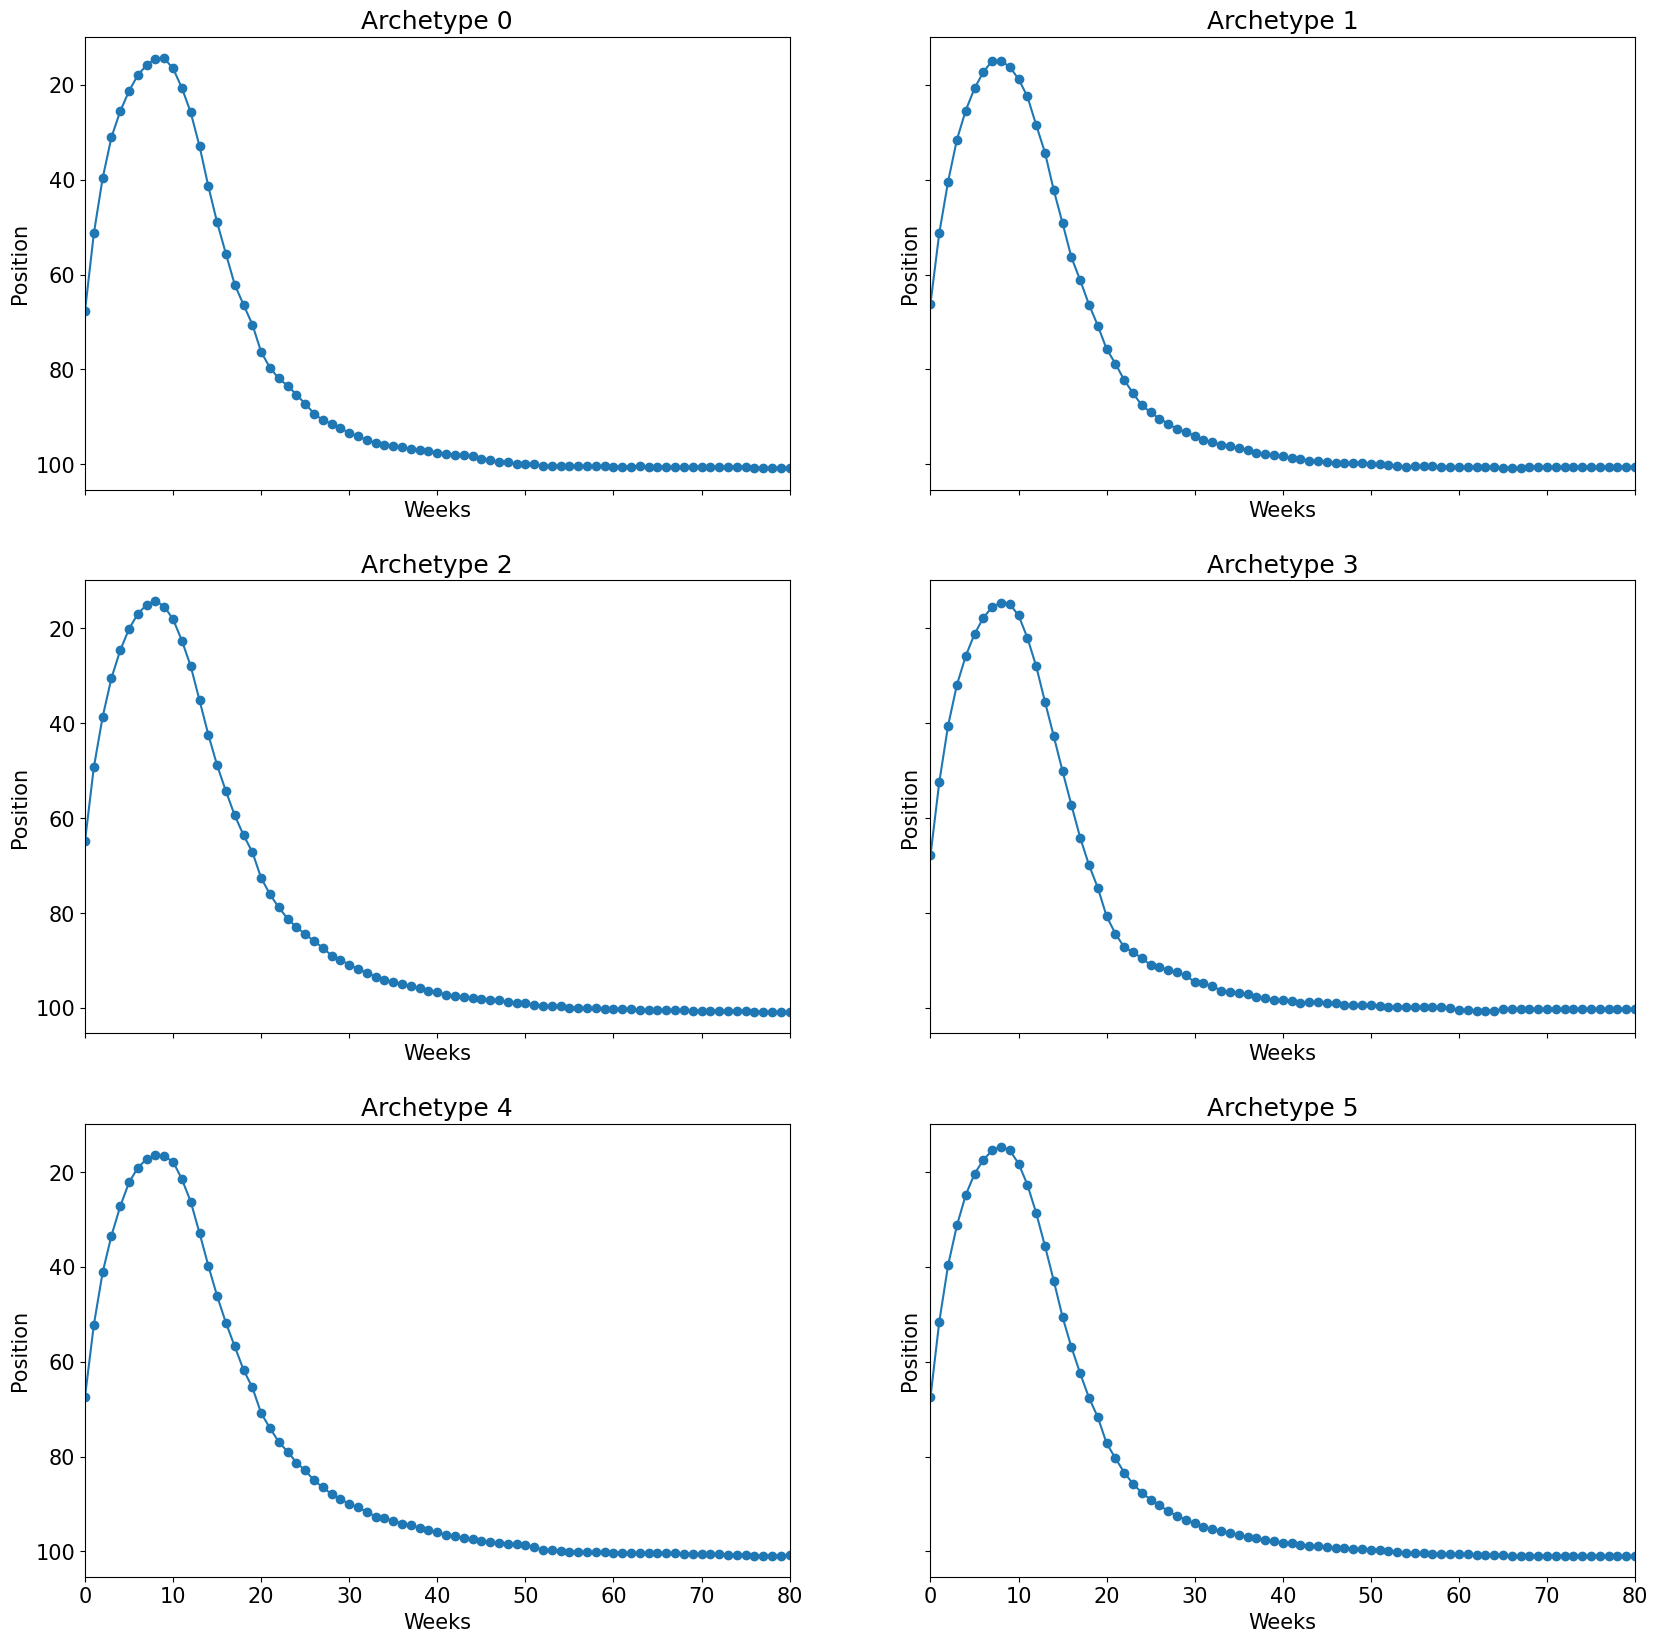

In [19]:
# plot all trajectories of archetypes
fig, axes = plt.subplots(int(len(nmf.components_)/2), 2, figsize=(20, 20), sharex=True, sharey=True)
row_i, col_i = 0, 0

for ix, archetype in tqdm(enumerate(nmf.components_)):
    for top_position in range(10, 110, 10):
        songs_ids_from_archetype = archetypes[ix]
        songs_from_archetype = billboard_hot_100[billboard_hot_100["artist_song"].isin(songs_ids_from_archetype)]
        songs_from_archetype = songs_from_archetype[(songs_from_archetype["top_position"] <= top_position) &\
            (songs_from_archetype["top_position"] > top_position - 10)][["artist_song"]]
        songs_from_archetype = songs_from_archetype[["artist_song"]].drop_duplicates().merge(
            billboard_100_with_empty_weeks[["artist_song",
                "position", "first_day_of_the_week", "first_week"]], on=["artist_song"], how="left")
        axes[row_i, col_i].plot(songs_from_archetype.groupby("first_day_of_the_week")["position"].mean(),
            marker='o')
        
    axes[row_i, col_i].set_title(f"Archetype {ix}")
    axes[row_i, col_i].set_xlabel("Weeks")
    axes[row_i, col_i].set_ylabel("Position")

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1 

plt.xlim(0, 80)
plt.gca().invert_yaxis()
plt.show()

100%|██████████| 2000/2000 [00:01<00:00, 1583.58it/s]
6it [00:09,  1.54s/it]


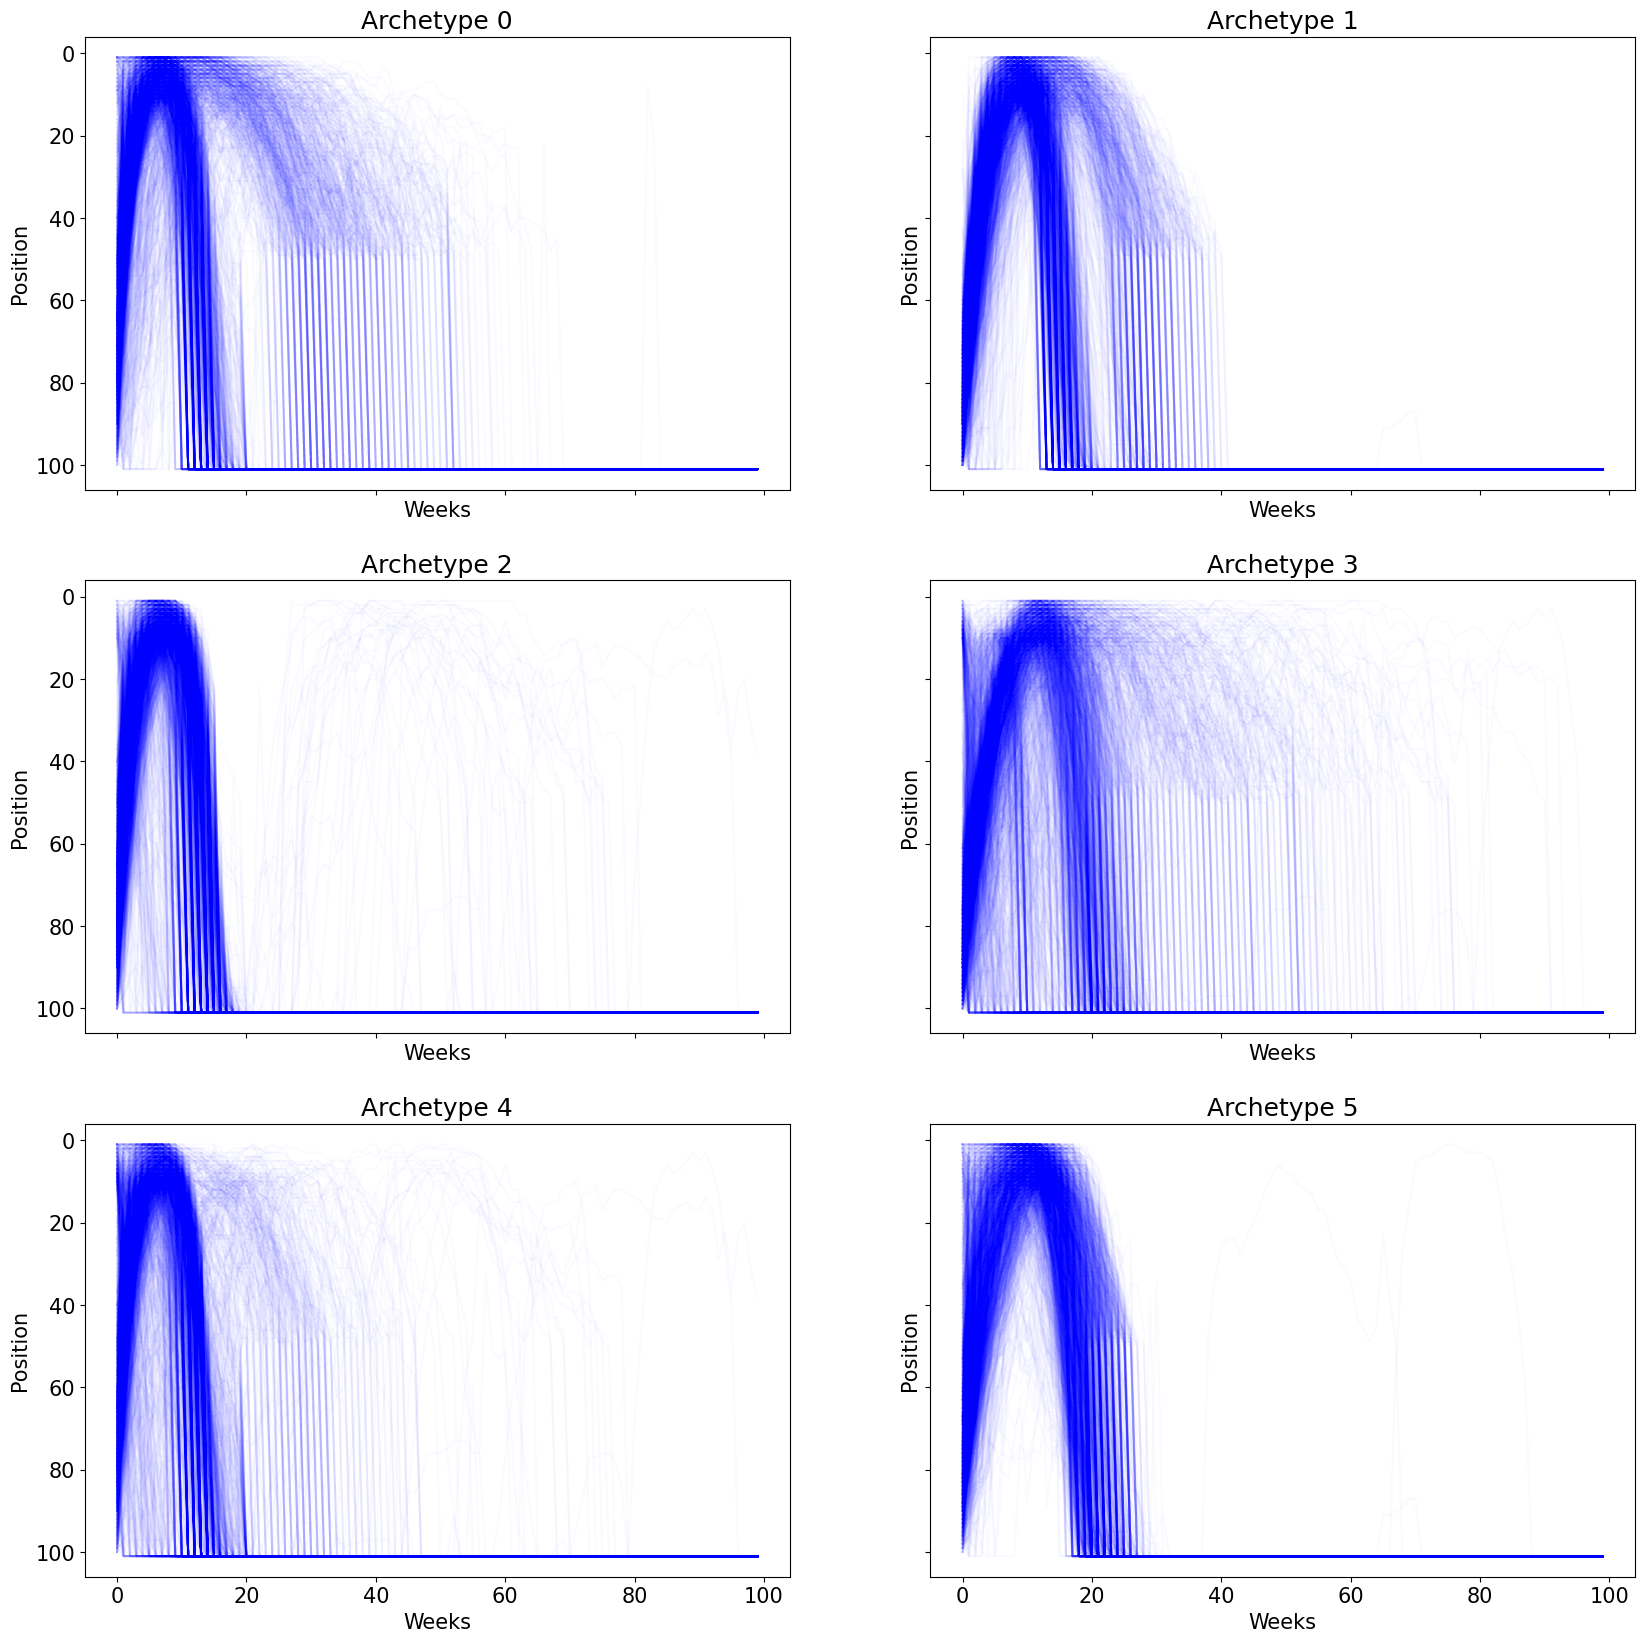

In [20]:
fig, axes = plt.subplots(int(len(nmf.components_)/2), 2, figsize=(20, 20), sharex=True, sharey=True)
row_i, col_i = 0, 0

for ix, archetype in tqdm(enumerate(nmf.components_)):
    for i in tqdm(archetype.argsort()[:-2000 - 1:-1]):
        # songs_ids_from_archetype = archetypes[ix]
        # songs_from_archetype = billboard_hot_100[billboard_hot_100["artist_song"].isin(songs_ids_from_archetype)]
        trajectory = pv_table.iloc[:, i].values
        #trajectory = trajectory[trajectory != 101]
        axes[row_i, col_i].plot(trajectory, alpha=0.02, color="blue")
    
    axes[row_i, col_i].set_title(f"Archetype {ix}")
    axes[row_i, col_i].set_xlabel("Weeks")
    axes[row_i, col_i].set_ylabel("Position")


    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1 

plt.gca().invert_yaxis()
plt.show()

100%|██████████| 2000/2000 [00:01<00:00, 1298.06it/s]
6it [00:10,  1.72s/it]


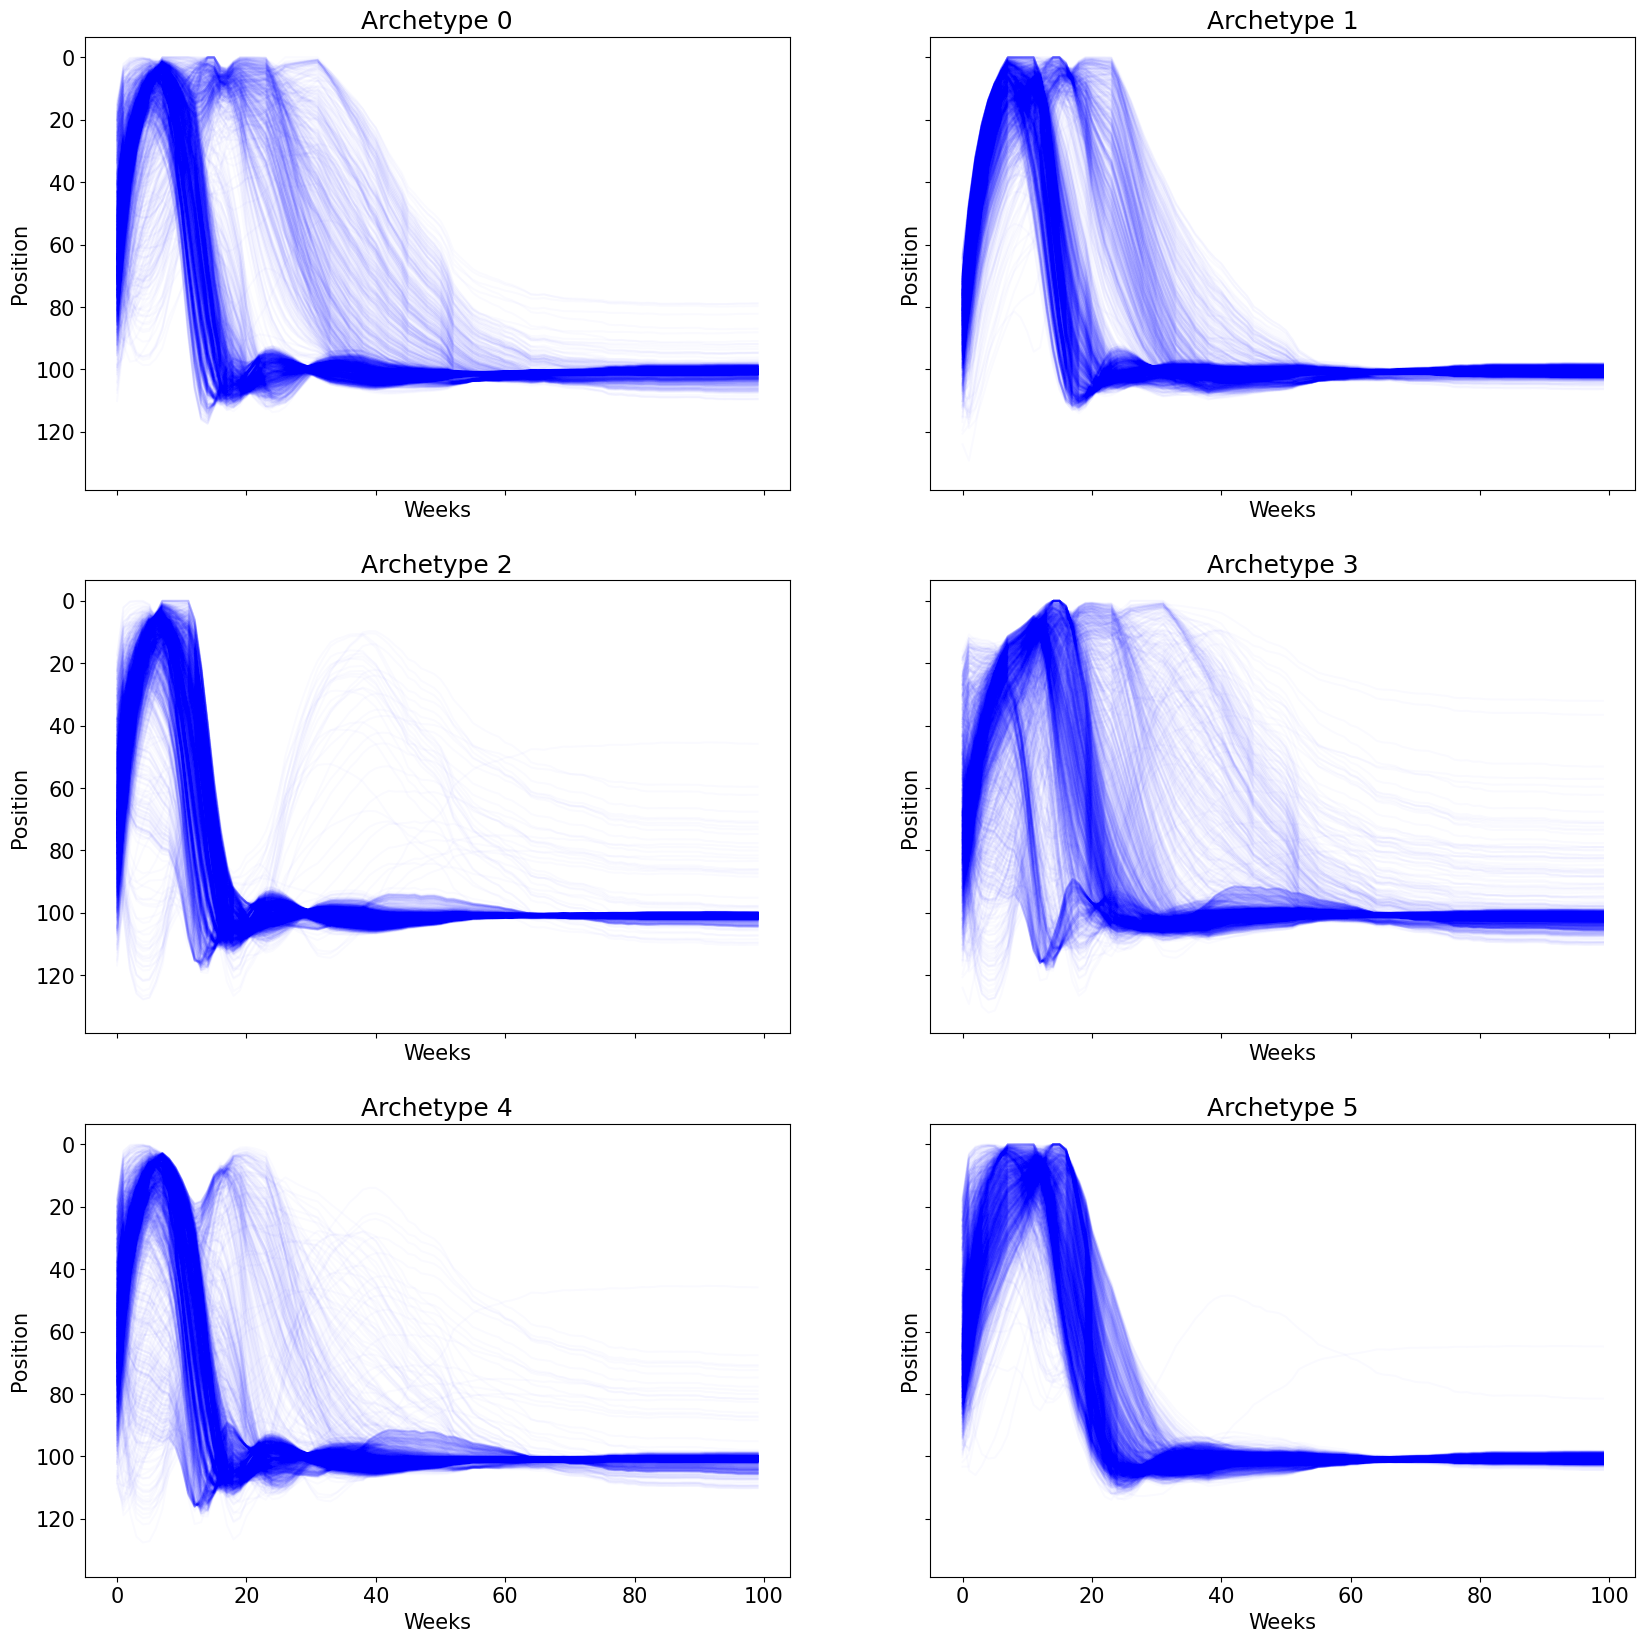

In [24]:
fig, axes = plt.subplots(int(len(nmf.components_)/2), 2, figsize=(20, 20), sharex=True, sharey=True)
row_i, col_i = 0, 0

for ix, archetype in tqdm(enumerate(nmf.components_)):
    for i in tqdm(archetype.argsort()[:-2000 - 1:-1]):
        # songs_ids_from_archetype = archetypes[ix]
        # songs_from_archetype = billboard_hot_100[billboard_hot_100["artist_song"].isin(songs_ids_from_archetype)]
        trajectory = np.matmul(nmf_features_pd, components_df.values[:, i])
        #trajectory = trajectory[trajectory != 101]
        axes[row_i, col_i].plot(trajectory, alpha=0.02, color="blue")
    
    axes[row_i, col_i].set_title(f"Archetype {ix}")
    axes[row_i, col_i].set_xlabel("Weeks")
    axes[row_i, col_i].set_ylabel("Position")


    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1 

plt.gca().invert_yaxis()
plt.show()

In [22]:
billboard_hot_100["archetype"] = billboard_hot_100["artist_song"].progress_apply(lambda x: components_df[x].argmax())


100%|██████████| 103545/103545 [00:05<00:00, 19391.62it/s]


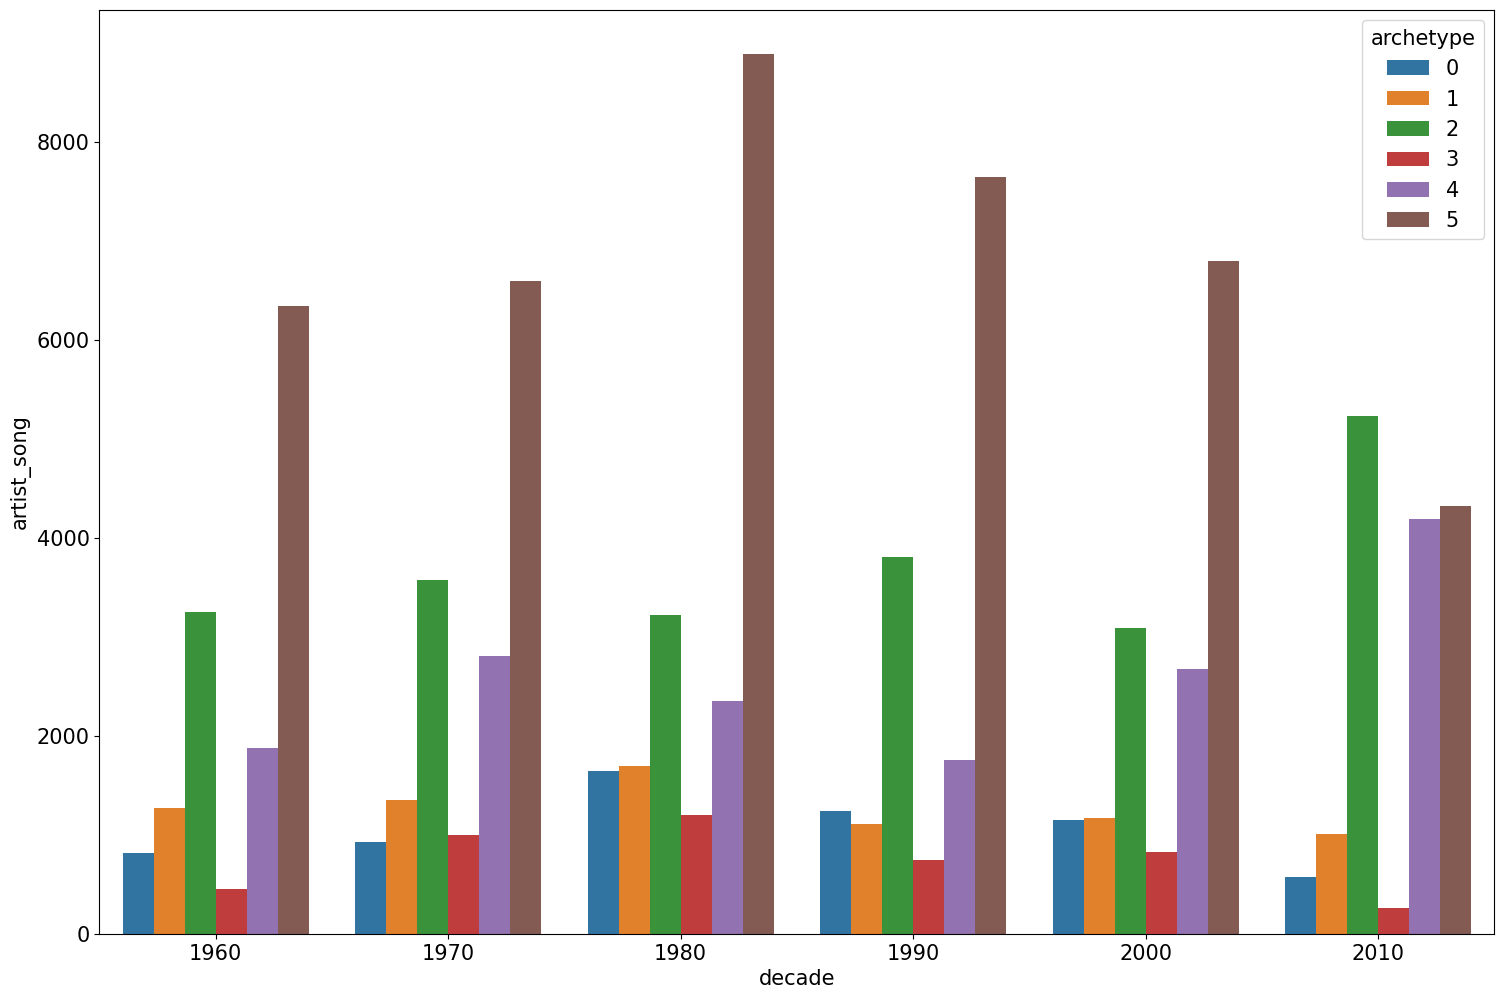

In [23]:
import seaborn as sns

plt.figure(figsize=(18, 12))

billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week_copy"].dt.year
billboard_hot_100["decade"] = billboard_hot_100["year"].apply(lambda x: x - x % 10)
counts = billboard_hot_100[["archetype", "decade", "artist_song"]].groupby(["archetype", "decade"]).count().reset_index()
counts = counts[(counts["decade"] != 2020) & (counts["decade"] != 1950)]
sns.barplot(counts, x="decade", y="artist_song", hue="archetype")

plt.show()